<a href="https://colab.research.google.com/github/envirodatascience/final-project-urban-treeam/blob/main/Les_UtilityLines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Urban tree cover is important for many reasons, ranging from public health to climate adaptation and mitigation. In New Haven, CT, one of the major agents in urban greening and tree planting is the Urban Resources Initiative (URI).
URI is a university-non profit partnership with Yale University.
URI has been planting trees along streets and in parks across New Haven for almost 20 years, while also producing research focused on the practice of urban forestry.

Recently, URI received a large ($2.6 million) grant from the United States Department of Agriculture’s Urban and Community Forestry Grant Program to plant more trees, specifically focusing on historically underserved, low-canopy neighborhoods. This essentially doubles the tree-planting goals that URI has, in terms of the number of trees planted, over the next five years.


**What's Up With Powerlines?**

When a tree grows very tall under powerlines, the utility companies will send crews to prune branches that might interfere with or fall onto wires. Unfortunately, they are not incentivised to consider aesthetics, or the overall health of the tree, and may remove large healthy limbs that are deemed potentially problematic. This leads to a cycle of pruning-> tree becoming stressed and growing new sprouts which will further interfere with wires->pruning again, until a tree is grossly misshapen beyond recovery and doomed to decline and eventually die.

This process obviously creates environmental disamenities for the communities with trees. Trees might be visually unappealing, and as they decline, branches may die and fall onto the street or sidewalk. Simply stopping utility pruning isn't an option though, since tree interferrance with lines complicates maitenence, presents a serious fire risk, and might cause more outages and line damage following severe weather events.

Barring major infrastructural changes (such as burrying power cables), tree planting operations need to prepare for this reality. One of URI's practices, which is not employed by all tree-planting groups, is to avoid planting large trees under powerlines. This minimizes the risk of utility pruning harming the trees, but also limits their ecosystem services, simply because large trees absorb more carbon, filter more water, support more wildlife, and cast more shade.

Given this context, and the expansion of URI's operations, it is worthwhile to assess the qualitative effect of powerlines on trees, and how the practice of only planting small trees under powerlines has begun to shape the distribution of trees and ecosystem services throughout the city.

So, with that context, let's dive right in!

I'll start by loading the required packages.

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from plotnine import *

I am bringing in the data here. The first is the .csv of all tree points obtained from treekeeper. This is largely a bulk download; in making the query to download I did not filter much out.

The second data I bring in is a series of shapefiles for neighborhoods in New Haven.


In [ ]:
%%capture
! wget "https://raw.githubusercontent.com/envirodatascience/final-project-urban-treeam/main/all_trees_58_1713995132.csv"
dfnew=pd.read_csv("/content/all_trees_58_1713995132.csv")
! wget "https://github.com/envirodatascience/final-project-urban-treeam/raw/main/Neighborhoods.zip"
! unzip /content/Neighborhoods.zip
nbhds_new= "/content/New_Haven_CT_Neighborhoods.shp"
nbhds_new=gpd.read_file(nbhds_new)
nbhds_new.rename(columns={'Neighbor_1': 'Neighborhood'}, inplace=True)

Below are the first few rows. As can be seen, each point is a tree, with all its associated information.

In [ ]:
new_column_names = {
    '(Common) Species': 'Common_Name',
    'Utility Wire Conflict': 'Wire',
    '(Botanical) Species (Genus)': 'Genus',
    'Valuation Total': 'Valuation_Total',
    'Last Editor': 'Last_Editor',
    'Planting Organization':'org',
    'Planted Date':"plant_date"
}

dfnew = dfnew.rename(columns=new_column_names)
df=dfnew
nbhds=nbhds_new
df.head()

,Site ID,Latitude,Longitude,(Botanical) Species,Common_Name,Condition,DBH,Wire,Grow Space,org,Neighborhood,plant_date,Department,Genus,(Common) Species (Genus),Last_Editor,Valuation_Total,Valuation Type,Sites
0,4,41.328957,-72.975426,Vacant Site,Vacant Site,Stump,27.0,Yes,Sidewalk Planting Strip,NaN,Amity,NaN,Street Tree,Vacant Site,Vacant Site,Les Welker,0.0,Estimate,4
1,5,41.265270,-72.892364,Gleditsia triacanthos,Honeylocust,NaN,23.0,No,Sidewalk Tree Pit,NaN,East Shore,NaN,Street Tree,Gleditsia,Honeylocust,Mitch Baron,415.0,Estimate,5
2,6,41.323589,-72.908722,Cornus florida,"Dogwood, Flowering",NaN,18.0,No,Sidewalk Tree Pit,NaN,East Rock,NaN,Street Tree,Cornus,Dogwood,Mitch Baron,415.0,Estimate,6
3,7,41.263393,-72.890724,Cornus kousa,"Dogwood, Kousa",NaN,3.0,No,Sidewalk Tree Pit,NaN,East Shore,NaN,Street Tree,Cornus,Dogwood,Mitch Baron,415.0,Estimate,7
4,8,41.326874,-72.916588,Cornus kousa,"Dogwood, Kousa",NaN,4.0,No,Sidewalk Tree Pit,NaN,Prospect Hill,NaN,Street Tree,Cornus,Dogwood,Mitch Baron,415.0,Estimate,8


Based on prior knowlege of the dataset, I know there are some specific things I want to filter out.

1. There are some vacant sites, which are labeled as such in their latin and common names. These don't represent trees anymore, so I don't want to include them.

2. There are park and greenspace trees included in this dataset. I only want to assess street trees.

3. There is a "last editor" whose name is associated with all the trees that have not been edited since the city and URI started using the Treekeeper software and formally registering the presence of powerlines. I am removing all these records because there is no way to assign them to utility wire presence with any amount of certainty (with my resources and skill set). The exception is for the Fair Haven neighborhood, which was inventoried just prior to the migration of data and does have fairly complete powerline and condition data, so I retain those points.

4. I am removing trees without a recorded condition. This is not common for trees that have been inventoried or maintained, but there are still a few.

Below is a histogram of points by their DBH (diameter at breast height; a common means of measuring how large a trunk is in forestry). These DBH are in inches. You can see one point that is extremely high, which I believe is missing a decimal point; the usual practice is to round up to whole numbers but this is occasionally not followed. There are also some points with a DBH of zero. I don't know what leads to this; I have visited some of these points in the field in the past, and they are all from before the shift to treekeeper, but some simply don't exist. I am removing them all to be safe, leading to the final filtering critera:

5. DBH of 0 and greater than 86 is removed

In [ ]:
dfAll=df
numrows=len(df)
df = df[~df['Common_Name'].str.contains('Vacant Site', case=False)]
numrows2=(len(df))
print("# Vacant sites removed: ",numrows-numrows2)

df = df[df['Department'].str.contains('Street Tree', case=False)]
numrows=(len(df))
print("# Non-street trees removed:  ",numrows2-numrows)

df = df[~((df['Last_Editor'].str.contains('Alex Foreman', case=False)) & (df['Neighborhood'] != "Fair Haven"))]
numrows2=(len(df))
print("# Points not updated since TK-migration (excluding Fair Haven) removed:  ",numrows-numrows2)

df.dropna(subset=['Condition'], inplace=True)
numrows=(len(df))
print("# trees without conditon removed:  ",numrows2-numrows)

df.DBH=df.DBH.round(decimals=0)
df = df[df['DBH'] < 86]
df = df[df['DBH'] != 0]
numrows2=(len(df))
print("# trees disqualified by DBH removed:  ",numrows-numrows2)

df = df[df['Longitude'] >= -73]
numrows=(len(df))
print("# trees outside of New Haven removed:  ",numrows2-numrows)

print("trees remaining: ", len(df))


# Vacant sites removed:  102
# Non-street trees removed:   2608
# Points not updated since TK-migration (excluding Fair Haven) removed:   10075
# trees without conditon removed:   2088
# trees disqualified by DBH removed:   31
# trees outside of New Haven removed:   0
trees remaining:  15674


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15674 entries, 6 to 30577
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Site ID                   15674 non-null  int64  
 1   Latitude                  15674 non-null  float64
 2   Longitude                 15674 non-null  float64
 3   (Botanical) Species       15674 non-null  object 
 4   Common_Name               15674 non-null  object 
 5   Condition                 15674 non-null  object 
 6   DBH                       15674 non-null  float64
 7   Wire                      15674 non-null  object 
 8   Grow Space                15674 non-null  object 
 9   org                       3694 non-null   object 
 10  Neighborhood              15674 non-null  object 
 11  plant_date                3948 non-null   object 
 12  Department                15674 non-null  object 
 13  Genus                     15674 non-null  object 
 14  (Common) Sp

This brings the number of sites from 30504 to 13436, a little less than half.

Next, I thought it would be valuble to see the distribution of the remaining trees in New Haven.

In [ ]:
from shapely.geometry import Point
nbhds = nbhds.to_crs(epsg=4326)
#assigning geometry points to the selected tree sites based on lat and long values, then creating a gdf to align with neighborhood polygons
df['points_geometry'] = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in zip(df['Longitude'], df['Latitude'])],crs=nbhds.crs)
nbhds_with_counts = df.groupby('Neighborhood').size().reset_index(name='selected_trees')
nbhds = nbhds.merge(nbhds_with_counts, on='Neighborhood', how='left')
nbhds = nbhds.merge(dfAll['Neighborhood'].value_counts(), on='Neighborhood', how='left')
nbhds.rename(columns={'count': 'All_Trees'}, inplace=True)
nbhds['perc_total'] = (nbhds['selected_trees'] / nbhds['All_Trees']) * 100

Notably, wooster square and mill river both have "NA" trees. This is because the original dataset lumps these two neighborhoods together. No inventory has been recently conducted, so there are very few usable datapoints from these two neighborhoods anyway.

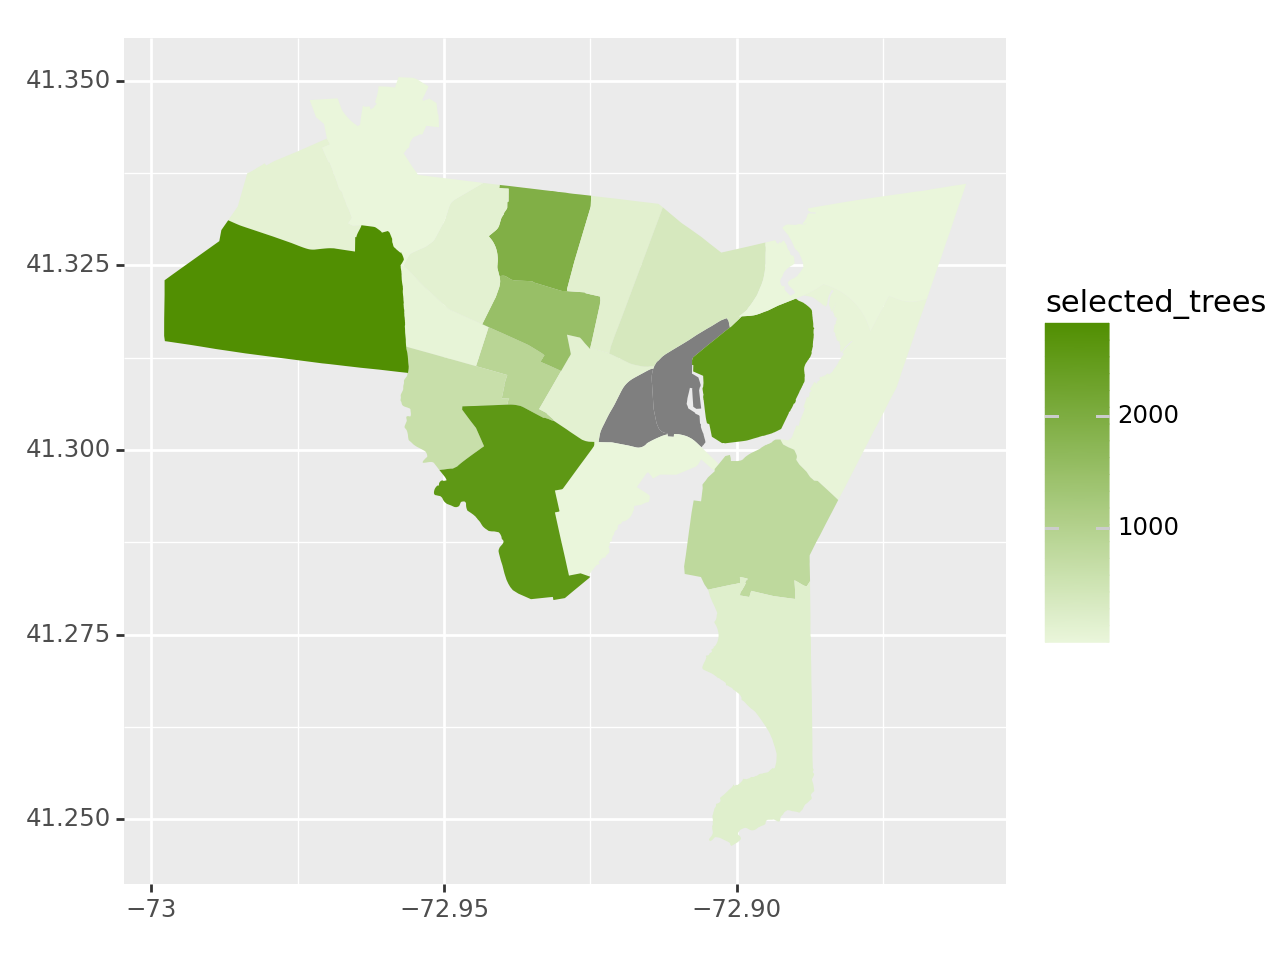

<Figure Size: (640 x 480)>

In [ ]:
(
  ggplot()
   + geom_map(nbhds, aes(geometry='geometry', fill="selected_trees"),color=None)
   + scale_fill_gradient(low="#eaf6db", high="#518f02")
)

The number of trees retained after the data cleaning earlier is just over a third of trees in the city. There are clear hotspots, but we know that tree canopy in general is not evenly distributed in reality, so its possible that the distribution we see here is partially due to that. To double check, I map the percent of all trees that were kept after data cleaning for each neighborhood.

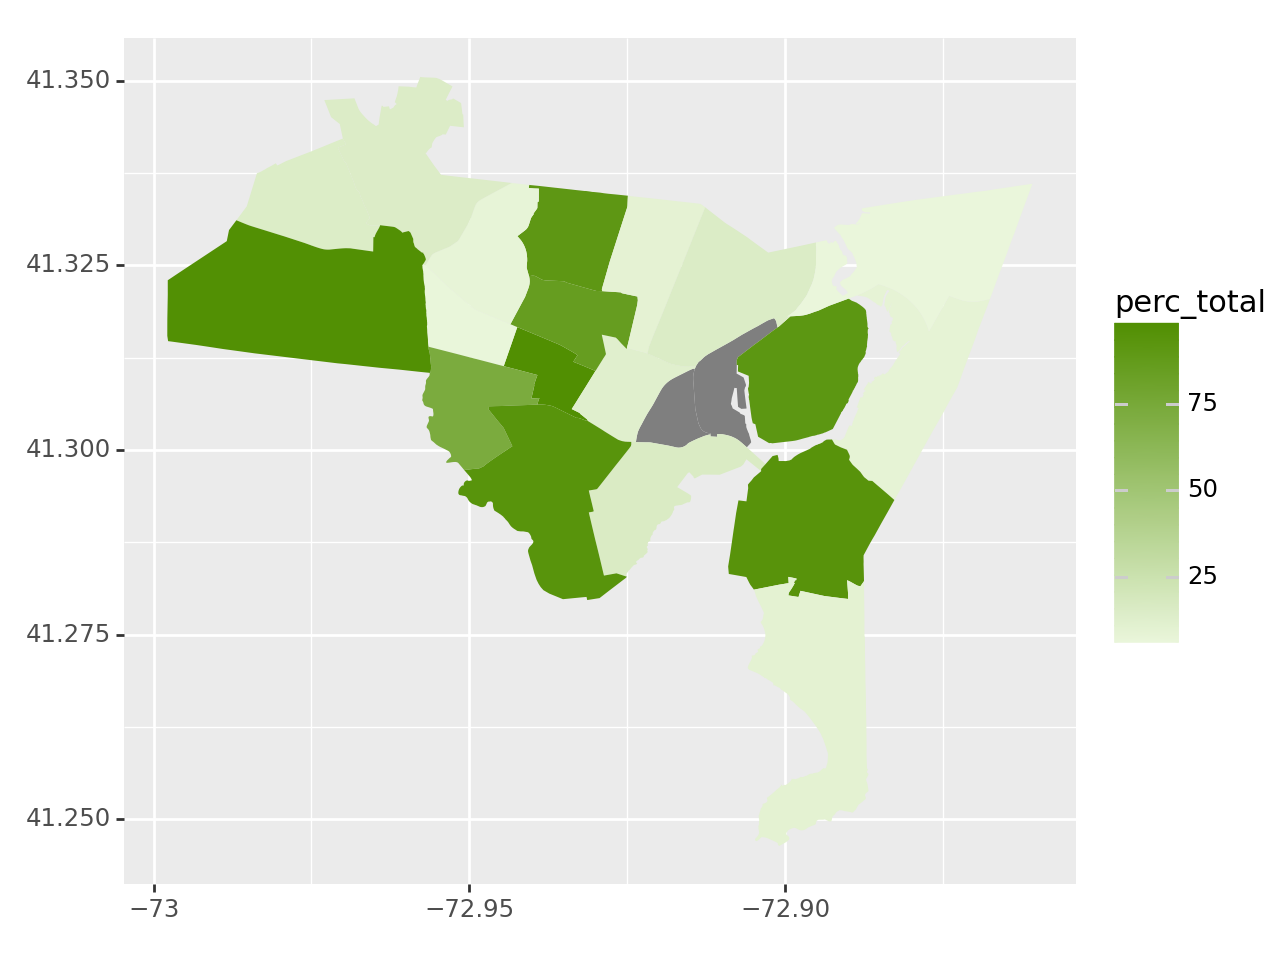

<Figure Size: (640 x 480)>

In [ ]:
(
  ggplot()
   + geom_map(nbhds, aes(geometry='geometry', fill="perc_total"),color=None)
   + scale_fill_gradient(low="#eaf6db", high="#518f02")
)

This second map shows the percent of trees kept, out of all the tree in the original dats set. Most neighborhoods have either most of their trees retained or near none of them retained. This clearly aligns with where URI has been conducting inventories. This map identifies for us which neighborhoods have complete-enough data for this analysis.  I will proceed by retaining only points which belong to neighborhoods with at least 75% of their trees retained. Yes, this number is arbitrary, but sits just below the clear naturally occuring gap in data completeness

In [ ]:
nbhds=nbhds[nbhds['perc_total']>75]

# Keep only the rows in df where the value in 'Column_Name' is present in df2
df = df[df['Neighborhood'].isin(nbhds['Neighborhood'].unique())]

Now a second histogram of trees by DBH remaining. That huge spike at 2 inches is all the recently planted trees (within 5 years). At 5 years, trees are revisited and usually DBH is updated; some trees will still be small.

There are a few ways to interpret this histogram. I believe the most correct is that there is a visible legacy of the low canopy cover and recent loss of large trees from disturbances and pests like Emerald ashborer, as well as the signal at lower DBHs of URI's tree planting efforts. The sheer number of small-DBH trees will include some species which can potentially grow large, but have only obtained a size of less than 20 DBH so far. There is clearly a drop-off of tree survival in the very early stages; this is why URI focuses so much on early care, to improve survival.

Finally, the number of trees in excellent condition remains low, and the share of trees in fair and poor condition grows somewhat between 10 and 20 DBH.

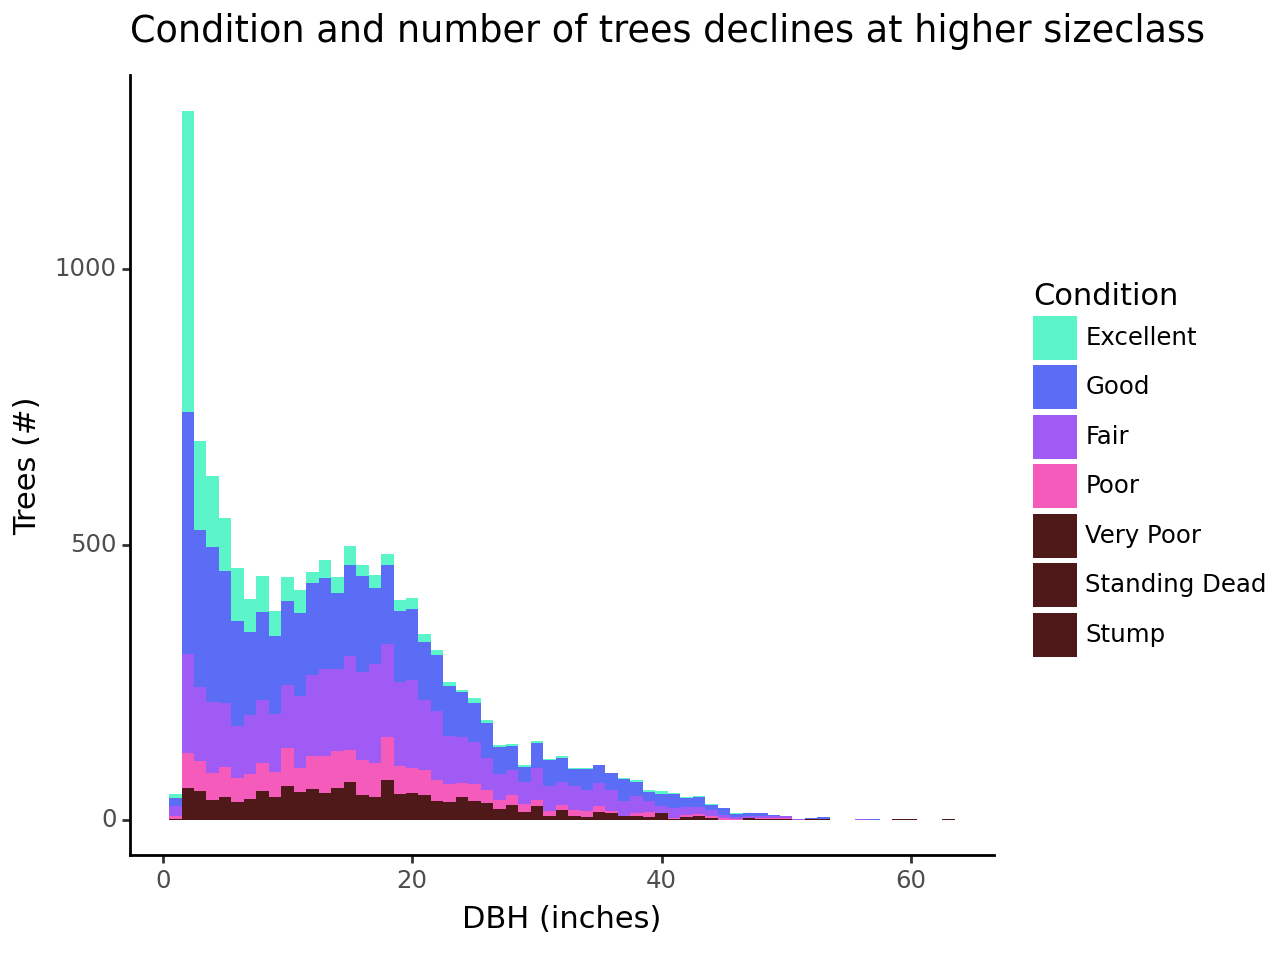

<Figure Size: (640 x 480)>

In [ ]:
condition_order = ['Excellent', 'Good', 'Fair', "Poor","Very Poor","Standing Dead","Stump"]
df['condition_order'] = pd.Categorical(df['Condition'], categories=condition_order, ordered=True)
(
ggplot(df, aes(x='DBH', fill="condition_order")) +
    geom_histogram(binwidth=1, position="stack") +
    labs(x='DBH (inches)', y='Trees (#)', title='Condition and number of trees declines at higher sizeclass') +
  scale_fill_manual(values=['#5bf5c9', '#5b6df5', '#a05bf5',"#f55bba","#4f1919","#4f1919","#4f1919"], name="Condition")+
  theme_classic()
)

Next, I want to set a few different goals.
#1. Calculate the percentage of trees under powerlines in each neighborhood
#2. calculate the average DBH of trees under powerlines and not under powerlines
#3. calculate and vizualize the average health of trees under powerlines and not under powerlines.

Here is a little bit of prep:

In [ ]:
# Assigning numerical values for tree health
condition_mapping = {
    'Stump': 0,
    'Standing Dead': 0,
    'Very Poor': 1,
    'Poor': 2,
    'Fair': 3,
    'Good': 4,
    'Excellent': 5
}
df['Condition'] = df['Condition'].replace(condition_mapping)

#creating "wire" and "no wire" subsets.
df_yes = df[df['Wire'] == 'Yes']
df_no = df[df['Wire'] == 'No']

Here are the calculations:

In [ ]:

#% of trees under wires in each neighborhood
nbhds = nbhds.merge(df_yes['Neighborhood'].value_counts().reset_index(), on='Neighborhood', how='left')
nbhds.rename(columns={'count': 'Wire_Trees'}, inplace=True)
nbhds['perc_wire'] = (nbhds['Wire_Trees'] / nbhds['selected_trees']) * 100
nbhds.head()

#the average condition of trees under wire or not under wire in each neighborhood
nbhds = nbhds.merge(df_yes.groupby('Neighborhood')['Condition'].mean().reset_index(), on='Neighborhood', how='left')
nbhds.rename(columns={'Condition': 'Wire_Condition'}, inplace=True)
nbhds = nbhds.merge(df_no.groupby('Neighborhood')['Condition'].mean().reset_index(), on='Neighborhood', how='left')
nbhds.rename(columns={'Condition': 'No_Wire_Condition'}, inplace=True)

#the average DBH of trees under wire or not under wire, excluding dead trees
df_yes_live = df_yes[df_yes['Condition'] != 0]
df_no_live = df_no[df_no['Condition'] != 0]
nbhds = nbhds.merge(df_yes_live.groupby('Neighborhood')['DBH'].mean().reset_index(), on='Neighborhood', how='left')
nbhds.rename(columns={'DBH': 'Wire_DBH'}, inplace=True)
nbhds = nbhds.merge(df_no_live.groupby('Neighborhood')['DBH'].mean().reset_index(), on='Neighborhood', how='left')
nbhds.rename(columns={'DBH': 'No_Wire_DBH'}, inplace=True)


I'd like to viz these results

In [ ]:
#this code helps me basically refactor neighborhoods to make my graph look nicer
plotdata=nbhds
plotdata.perc_wire=plotdata.perc_wire.round(decimals=1)

plotdata['Neighborhood'] = pd.Categorical(plotdata['Neighborhood'])
neighborhood_map = plotdata.set_index('Neighborhood')['perc_wire'].to_dict()

# Then, reorder the factor levels of the "Neighborhood" column based on the perc_wire values
neighborhood_order = sorted(plotdata['Neighborhood'], key=lambda x: neighborhood_map[x])

# Finally, update the "Neighborhood" column with the reordered factor levels
plotdata['Neighborhood'] = pd.Categorical(plotdata['Neighborhood'], categories=neighborhood_order, ordered=True)


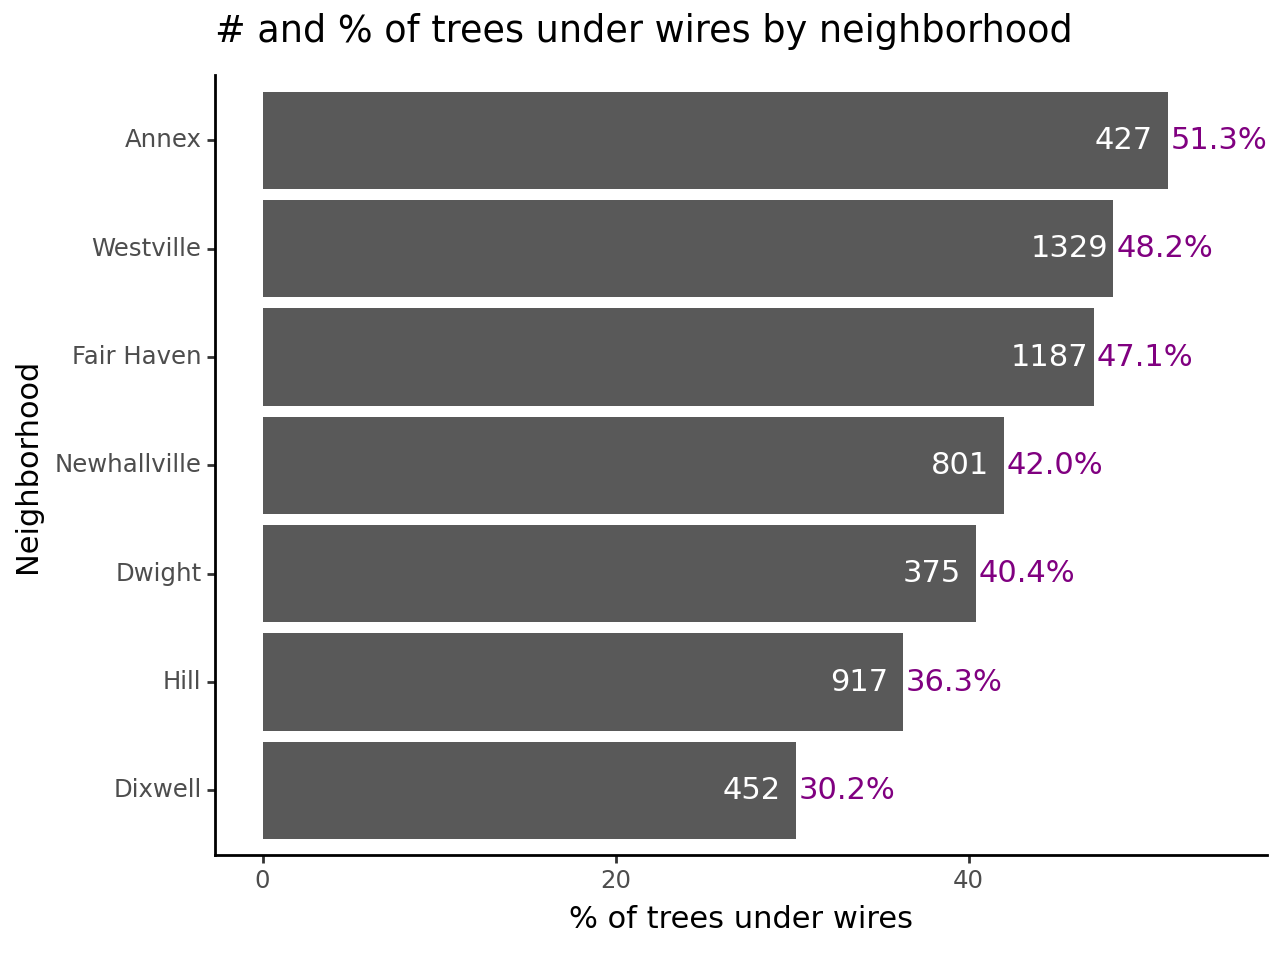

<Figure Size: (640 x 480)>

In [ ]:
plotdata['Neighborhood'] = pd.Categorical(plotdata['Neighborhood'])
(
  ggplot(plotdata)
   + geom_col(aes(x='Neighborhood', y='perc_wire'))
   + coord_flip()
   + geom_text(aes(x='Neighborhood', y='perc_wire', label='Wire_Trees'), color='white', nudge_y = -2.5)
   + geom_text(aes(x='Neighborhood', y='perc_wire', label=plotdata['perc_wire'].astype(str) + "%"), color='purple', nudge_y = 2.9)
   + ylab("% of trees under wires")
   + ggtitle("# and % of trees under wires by neighborhood")
   + theme_classic()
)

The percentage of trees under wires ranges from 30.2 and 51.3 in the selected neighborhoods. I am not sure if this reflects differences in the amount of lines overall or not.

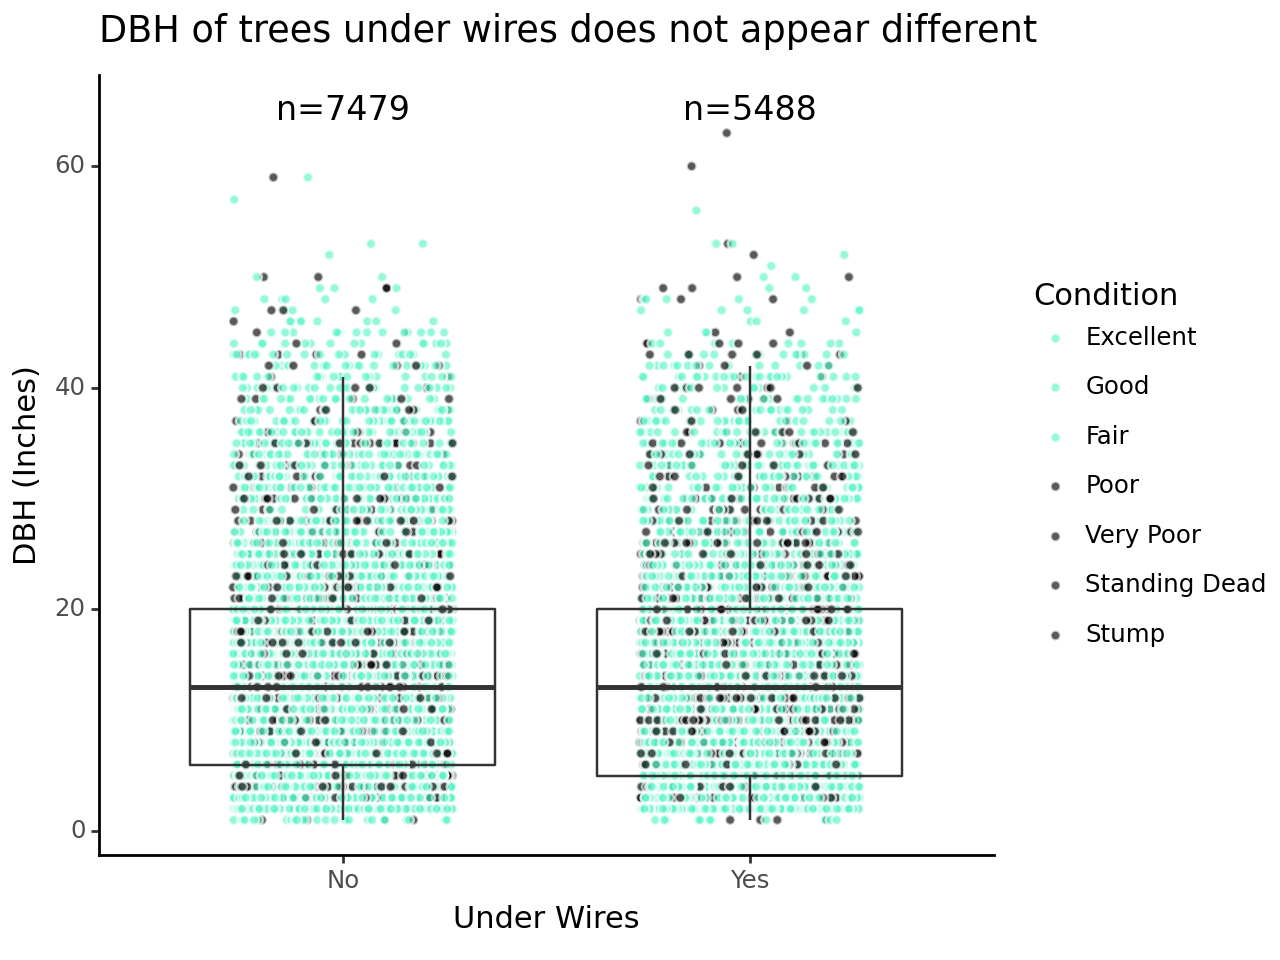

<Figure Size: (640 x 480)>

In [ ]:
wire_counts = df.groupby('Wire').size().reset_index(name='count')


(
ggplot(df, aes(x='Wire', y='DBH')) +
    geom_jitter(aes(fill="condition_order"),color="white",width=0.27, height=0, alpha=0.65) +
    geom_boxplot(alpha=1,outlier_alpha=0, fill=None) +
    geom_text(aes(label="n=" + wire_counts['count'].astype(str), x='Wire',y=65), data=wire_counts,size=12) +
    labs(x='Under Wires', y='DBH (Inches)', title='DBH of trees under wires does not appear different') +
    scale_fill_manual(values=['#5bf5c9', '#5bf5c9', '#5bf5c9',"Black","Black","Black","Black"], name="Condition")+
    theme_classic()
)


From this boxplot we can see that the DBH of trees under wires is not smaller than trees without wires. We are not yet seeing the effects of smaller trees being planted under wires across the landscape of New Haven reflected in DBH, probably because URI is planting similar numbers of trees under wires as not under wires, and neither subset has grown enough to be notably different from each other, at least not enough to offset the legacy of older large trees on the landscape. Condition is harder to ascertain, though there seems to be more black points (signifying low-health trees) in the "yes" column, to me. I'll run a quick T-test to check this.

In [ ]:
t_statistic, p_value = stats.ttest_ind(df_yes['Condition'], df_no['Condition'], equal_var=False)
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in the means of condition for trees under wires and trees not under wires.")
else:
    print("There is NO statistically significant difference in the means of condition for trees under wires and trees not under wires.")

There is a statistically significant difference in the means of condition for trees under wires and trees not under wires.


Well, that speaks for itself.

I'd like to visualize the differences in condition for trees under wires or not under wires. My approach to this is first creating buckets for DBH, since I'd expect small trees to have the least response to wires, but not necessarily that large trees would be having the most response. It is plausible that the largest trees could only obtain that great size through especially careful (or lax) pruning or unique individual resilliance which essentially filtered other trees out early. Mid sized trees are an interesting group to look at independantly and in comparison to others.

In [ ]:
bins = [0,5,10,20,30,40, float('inf')]
labels = ['DBH: ≤5 in','DBH: 6-10 in', 'DBH: 11-20 in', 'DBH: 21-30 in', 'DBH: 31-40 in','DBH: >40 in']
#colors = ['#9fc5e8', '#ffe599', '#e06666', '#741b47']

df['Size_Class'] = pd.cut(df['DBH'], bins=bins, labels=labels, right=True)
df.groupby(['Size_Class'])['org'].count().reset_index(name='Count')


,Size_Class,Count
0,DBH: ≤5 in,1952
1,DBH: 6-10 in,324
2,DBH: 11-20 in,89
3,DBH: 21-30 in,17
4,DBH: 31-40 in,6
5,DBH: >40 in,0


That table shows the number of trees in each of the size classes labeled with a planting organization. I have doubts about the validity of the trees with 20+ inch DBH (probably data entry error), but this is more to show that the vast majority of URI trees are in these smaller size classes.

In [ ]:
avg_conditions = df.groupby(['Size_Class', 'Wire'])['Condition'].mean().reset_index()

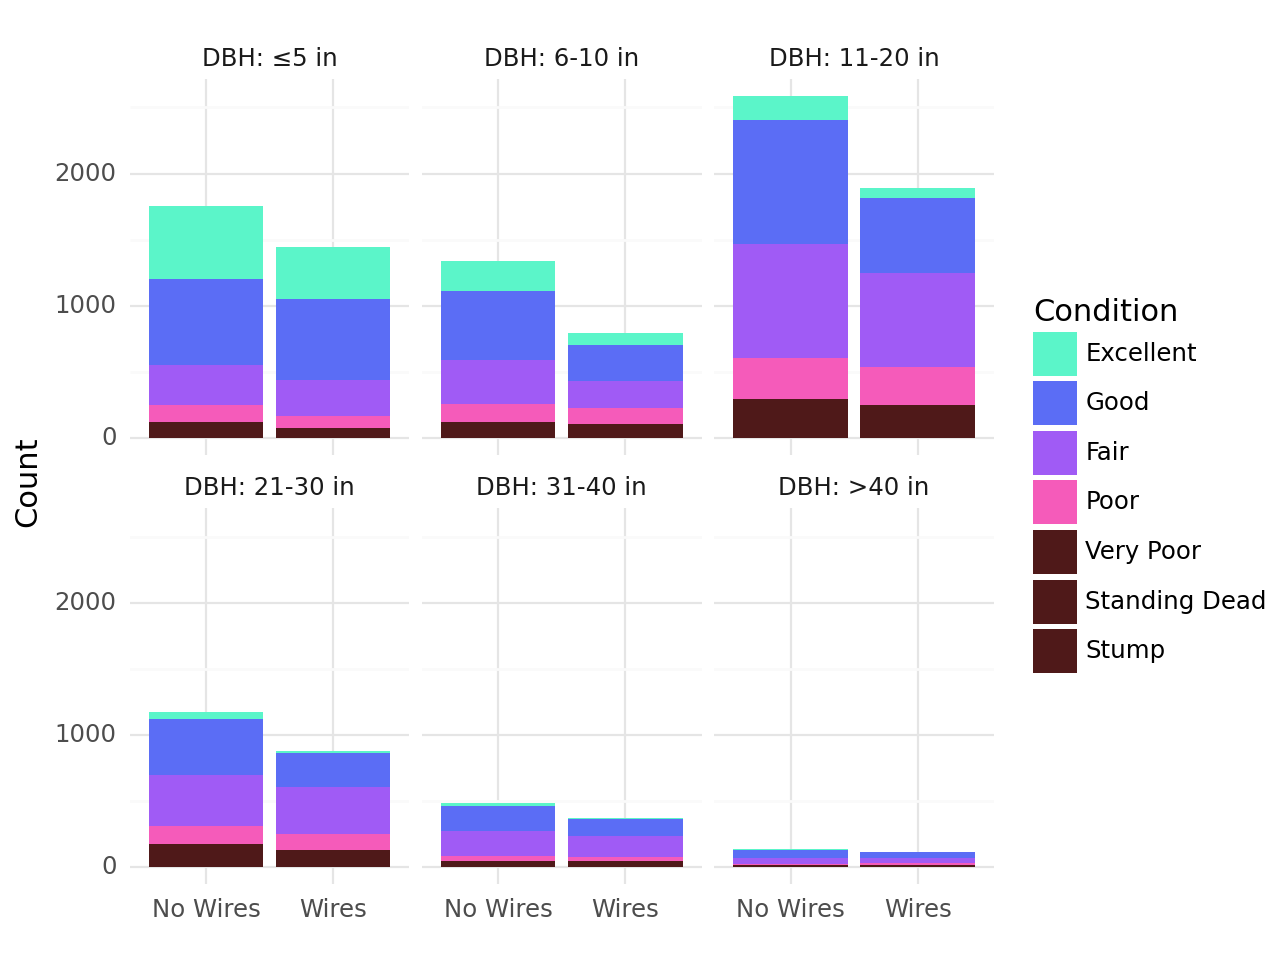

<Figure Size: (640 x 480)>

In [ ]:

(
  ggplot(df, aes(x='Wire', fill='condition_order')) +
    facet_wrap('~ Size_Class')+
    geom_bar(position='stack') +
    labs(x='', y='Count') +
    scale_fill_manual(values=['#5bf5c9', '#5b6df5', '#a05bf5',"#f55bba","#4f1919","#4f1919","#4f1919"], name="Condition")+
    scale_x_discrete(labels=["No Wires", "Wires"]) +
    theme_minimal() +
    theme(legend_position='right')  # Adjust legend position
)


From this graph, it looks like trees not under wires start out doing a little better than those not under wires. This gets exacerbated as the sizeclass increases. Despite having fewer trees in total, the overall number of trees doing "poor" or worse is roughly the same for the under-wire cohort as the no-wires one for all size classes greater than 5 in DBH.

I spent too long trying to add text for average condition value for each sizeclass/wire combo to the chart but just couldn't. Plotnine does not have all the functionality of ggplot in R, for sure. So just a table of it instead, showing that the average condition of trees under wires is lower than the average condition not under wires for most groups, with the exception of the smallest size class. The difference seems starkest in the 6-10 inch sizeclass, which is interesting, because these trees are generally small enough that I might not expect them to have had major pruning yet.


In [ ]:
avg_conditions

,Size_Class,Wire,Condition
0,DBH: ≤5 in,No,3.751281
1,DBH: ≤5 in,Yes,3.774619
2,DBH: 6-10 in,No,3.380988
3,DBH: 6-10 in,Yes,3.060759
4,DBH: 11-20 in,No,3.079212
5,DBH: 11-20 in,Yes,2.879767
6,DBH: 21-30 in,No,2.909710
7,DBH: 21-30 in,Yes,2.776136
8,DBH: 31-40 in,No,3.096907
9,DBH: 31-40 in,Yes,2.938172


In [ ]:
genus_counts = df[df["DBH"] >6].groupby(['Wire', 'Genus']).agg({'Condition': 'mean', 'Genus': 'count'}).rename(columns={'Genus': 'Count', 'Condition': 'Average_Condition'}).reset_index()
top_wire = genus_counts[(genus_counts['Wire'] == 'Yes') & (genus_counts['Genus'] != 'Stump')]
top_10_wire=top_wire.sort_values(by='Count', ascending=False).head(10)
next_ten = top_wire.sort_values(by='Count', ascending=False).iloc[10:19]
next_ten

,Wire,Genus,Average_Condition,Count
73,Yes,Ginkgo,2.454545,44
77,Yes,Liquidambar,3.825000,40
64,Yes,Carpinus,3.675676,37
94,Yes,Syringa,3.437500,32
72,Yes,Fraxinus,2.607143,28
93,Yes,Styphnolobium,3.285714,28
83,Yes,Phellodendron,2.666667,15
62,Yes,Amelanchier,3.583333,12
67,Yes,Celtis,3.083333,12


In [ ]:
top_ten = genus_counts[genus_counts['Genus'].isin(top_10_wire['Genus'])]
next_ten = genus_counts[genus_counts['Genus'].isin(next_ten['Genus'])]

next_ten

,Wire,Genus,Average_Condition,Count
4,No,Amelanchier,3.666667,6
6,No,Carpinus,3.458333,24
12,No,Cercis,3.500000,2
14,No,Cornus,2.800000,5
17,No,Crataegus,2.200000,5
21,No,Ginkgo,3.117647,17
28,No,Liquidambar,4.053763,93
30,No,Maackia,3.500000,2
52,No,Ulmus,3.008511,235
59,Yes,Amelanchier,3.666667,3


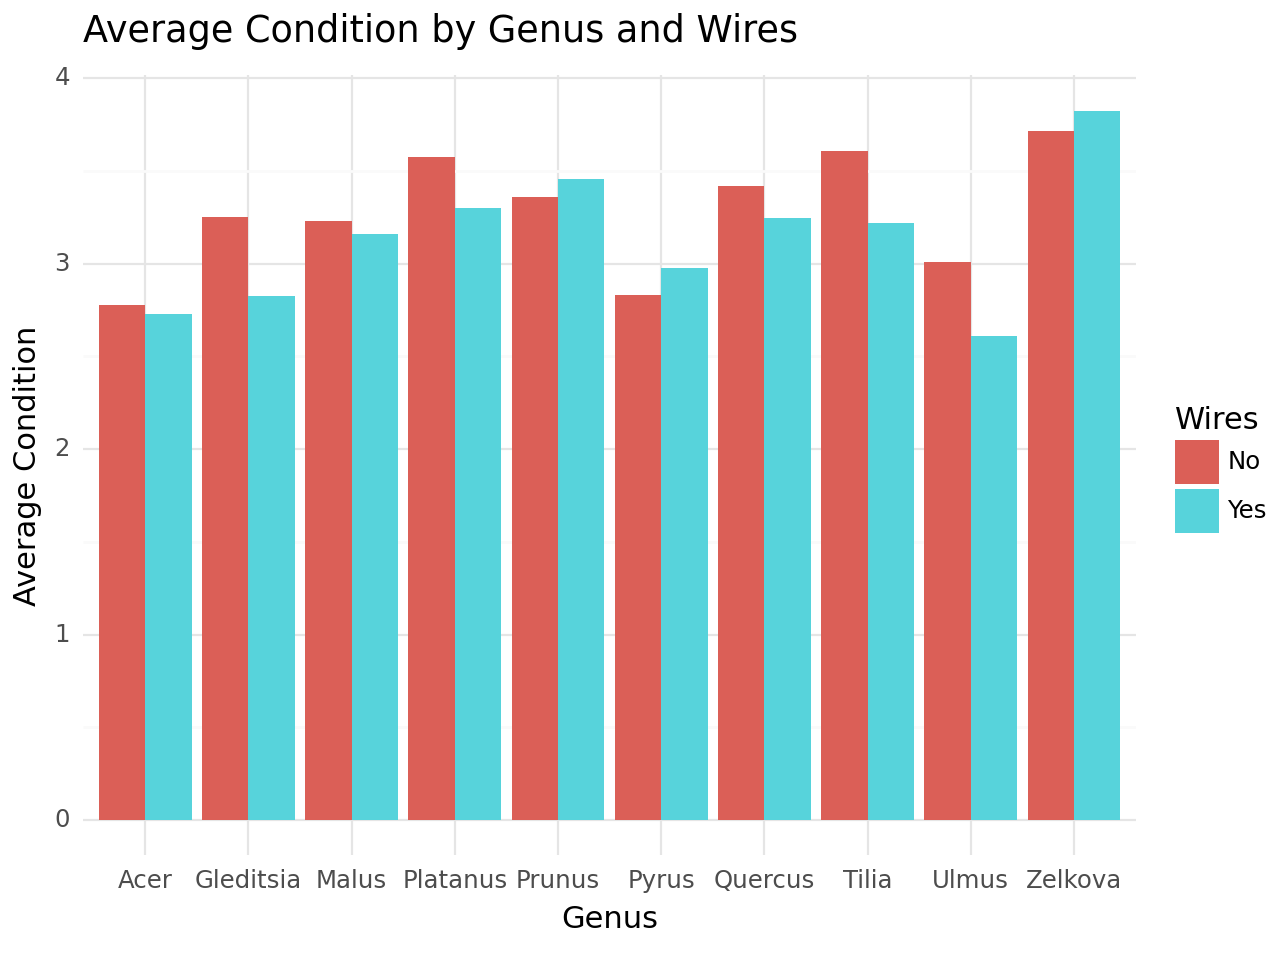

<Figure Size: (640 x 480)>

In [ ]:
(
    ggplot(top_ten, aes(x='Genus', y='Average_Condition', fill='Wire')) +
    geom_col(position='dodge') +
    labs(x='Genus', y='Average Condition', fill='Wires') +
    ggtitle('Average Condition by Genus and Wires') +
    theme_minimal()
)

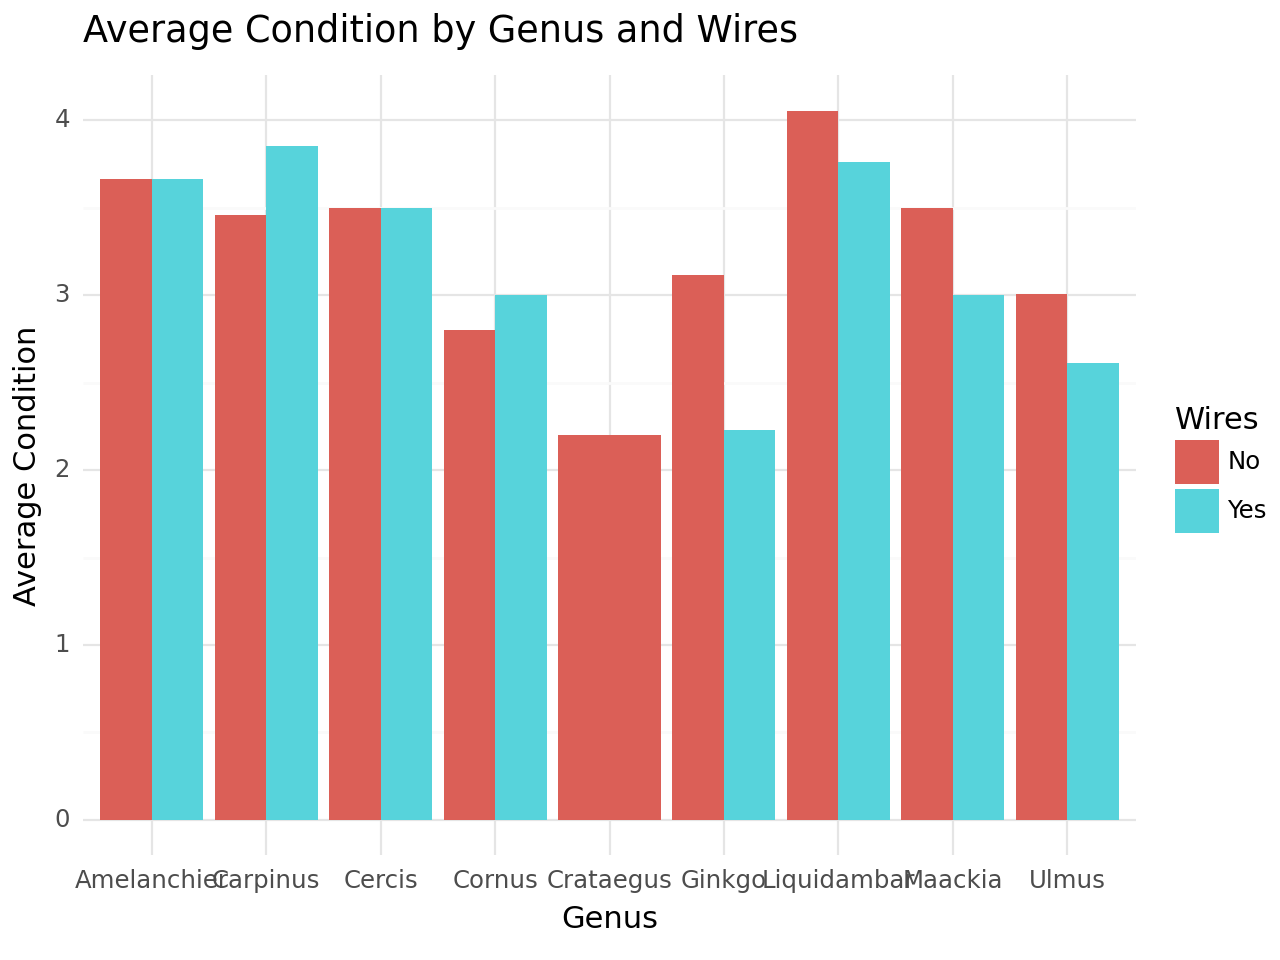

<Figure Size: (640 x 480)>

In [ ]:
(
    ggplot(next_ten, aes(x='Genus', y='Average_Condition', fill='Wire')) +
    geom_col(position='dodge') +
    labs(x='Genus', y='Average Condition', fill='Wires') +
    ggtitle('Average Condition by Genus and Wires') +
    theme_minimal()
)